In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import FeatureUnion
import lightgbm as lgb

# Load the CSV file
df=pd.read_csv("drive/MyDrive/CS506-DS/midterm/data/train.csv")
df=df.iloc[:60000]
print(df.keys())

# Convert ReviewId column to int
df['Id'] = df['Id'].astype(int)
df.drop(columns=["UserId","Time","Id"], axis=1, inplace=True)
df['Summary'] = df['Summary'].astype(str)
df['Text'] = df['Text'].astype(str)

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score'],
      dtype='object')


In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to compute the sentiment scores for a given text
def get_sentiment_scores(text):
    scores = analyzer.polarity_scores(text)
    return scores['neg'], scores['neu'], scores['pos'], scores['compound']

# Apply the function to the 'Text' and 'Summary' columns
df['Text_sentiment_neg'], df['Text_sentiment_neu'], df['Text_sentiment_pos'], df['Text_sentiment_compound'] = zip(*df['Text'].apply(get_sentiment_scores))
df['Summary_sentiment_neg'], df['Summary_sentiment_neu'], df['Summary_sentiment_pos'], df['Summary_sentiment_compound'] = zip(*df['Summary'].apply(get_sentiment_scores))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


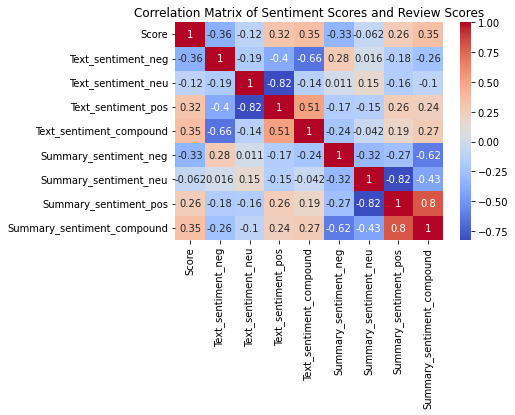

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df[['Score', 'Text_sentiment_neg', 'Text_sentiment_neu', 'Text_sentiment_pos', 'Text_sentiment_compound', 'Summary_sentiment_neg', 'Summary_sentiment_neu', 'Summary_sentiment_pos', 'Summary_sentiment_compound']].corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Sentiment Scores and Review Scores')
plt.show()

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import xgboost as xgb

# Remove any rows with missing values
df = df.dropna()

# Convert the Score column to a binary label
threshold = 3
df['label'] = (df['Score'] >= threshold).astype(int)

# Shuffle the rows
df = df.sample(frac=1, random_state=0)

# Reset the index
df = df.reset_index(drop=True)

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=0)

# Define the TfidfVectorizer for character n-grams
char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))

# Define the TfidfVectorizer for word n-grams
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3))

# Fit the vectorizers to the training data
X_train_char = char_vectorizer.fit_transform(train_df['Summary'])
X_train_word = word_vectorizer.fit_transform(train_df['Text'])

# Transform the validation data using the fitted vectorizers
X_val_char = char_vectorizer.transform(val_df['Summary'])
X_val_word = word_vectorizer.transform(val_df['Text'])

# Combine the TF-IDF features for training and validation data
X_train_tfidf = hstack([X_train_char, X_train_word])
X_val_tfidf = hstack([X_val_char, X_val_word])

# Define the LightGBM model for TF-IDF features
tfidf_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 30,
    'learning_rate': 0.06,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}
tfidf_model = lgb.LGBMRegressor(**tfidf_params)

# Train the model on the training data
tfidf_model.fit(X_train_tfidf, train_df['Score'], eval_set=[(X_val_tfidf, val_df['Score'])], early_stopping_rounds=10, verbose=10)

def extract_sentiment_features(df):
    return df[['Summary_sentiment_compound', 'Text_sentiment_compound']].values

# Define the feature union for sentiment features
sentiment_union = FeatureUnion([
    ('sentiment', FunctionTransformer(extract_sentiment_features, validate=False)),
    ('helpfulness', MaxAbsScaler())
])

# Compute the helpfulness ratio
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=0)

# Fit the feature union to the training data
X_train_sentiment = sentiment_union.fit_transform(train_df[['Summary_sentiment_compound', 'Text_sentiment_compound', 'HelpfulnessRatio']])
X_val_sentiment = sentiment_union.transform(val_df[['Summary_sentiment_compound', 'Text_sentiment_compound', 'HelpfulnessRatio']])

# Define the LightGBM model for sentiment features
sentiment_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 30,
    'learning_rate': 0.06,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}
sentiment_model = lgb.LGBMRegressor(**sentiment_params)
# Train the model on the training data
sentiment_model.fit(X_train_sentiment, train_df['Score'], eval_set=[(X_val_sentiment, val_df['Score'])], early_stopping_rounds=10, verbose=10)

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's rmse: 1.08984
[20]	valid_0's rmse: 1.03061
[30]	valid_0's rmse: 0.986595
[40]	valid_0's rmse: 0.955604


In [ ]:
test_df = pd.read_csv("drive/MyDrive/CS506-DS/midterm/data/X_test.csv")
test_df.drop(columns=["UserId","Score"], axis=1, inplace=True)

test_df = test_df.dropna()

# Shuffle the rows
test_df = test_df.sample(frac=1, random_state=0)

# Reset the index
test_df = test_df.reset_index(drop=True)


# Apply the function to the 'Text' and 'Summary' columns
test_df['Text_sentiment_neg'], test_df['Text_sentiment_neu'], test_df['Text_sentiment_pos'], test_df['Text_sentiment_compound'] = zip(*test_df['Text'].apply(get_sentiment_scores))
test_df['Summary_sentiment_neg'], test_df['Summary_sentiment_neu'], test_df['Summary_sentiment_pos'], test_df['Summary_sentiment_compound'] = zip(*test_df['Summary'].apply(get_sentiment_scores))


# Compute the helpfulness ratio
test_df['HelpfulnessRatio'] = test_df['HelpfulnessNumerator'] / test_df['HelpfulnessDenominator']

# Transform the test data using the fitted vectorizers
X_test_char = char_vectorizer.transform(test_df['Summary'])
X_test_word = word_vectorizer.transform(test_df['Text'])

# Combine the TF-IDF features for test data
X_test_tfidf = hstack([X_test_char, X_test_word])

# Make predictions using the TF-IDF model
tfidf_preds = tfidf_model.predict(X_test_tfidf)

# Transform the test data using the feature union
X_test_sentiment = sentiment_union.transform(test_df[['Summary_sentiment_compound', 'Text_sentiment_compound', 'HelpfulnessRatio']])

# Make predictions using the sentiment model
sentiment_preds = sentiment_model.predict(X_test_sentiment)

# Combine the predictions from both models
test_df['Score'] =  (0.65 * tfidf_preds) + (0.35 * sentiment_preds)


submission = test_df[['Id', 'Score']]
submission.to_csv("submission.csv", index=False)


multiclass score ( not best score )

In [ ]:
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import lightgbm as lgb

# Remove any rows with missing values
df = df.dropna()

# Convert the Score column to a tertiary label
df['label'] = pd.cut(df['Score'], bins=[0, 2, 4, 5], labels=['negative', 'neutral', 'positive'])

# Shuffle the rows
df = df.sample(frac=1, random_state=0)

# Reset the index
df = df.reset_index(drop=True)

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=0)

# Define the TfidfVectorizer for character n-grams
char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))

# Define the TfidfVectorizer for word n-grams
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3))

# Fit the vectorizers to the training data
X_train_char = char_vectorizer.fit_transform(train_df['Summary'])
X_train_word = word_vectorizer.fit_transform(train_df['Text'])

# Transform the validation data using the fitted vectorizers
X_val_char = char_vectorizer.transform(val_df['Summary'])
X_val_word = word_vectorizer.transform(val_df['Text'])

# Combine the TF-IDF features for training and validation data
X_train_tfidf = hstack([X_train_char, X_train_word])
X_val_tfidf = hstack([X_val_char, X_val_word])

# Define the LightGBM model for TF-IDF features
tfidf_params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_error',
    'num_leaves': 30,
    'learning_rate': 0.06,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}
tfidf_model = lgb.LGBMClassifier(**tfidf_params)

# Train the model on the training data
tfidf_model.fit(X_train_tfidf, train_df['label'], eval_set=[(X_val_tfidf, val_df['label'])], early_stopping_rounds=10, verbose=10)

def extract_sentiment_features(df):
    return df[['Summary_sentiment_compound', 'Text_sentiment_compound']].values
    
# Define the feature union for sentiment features
sentiment_union = FeatureUnion([
    ('sentiment', FunctionTransformer(extract_sentiment_features, validate=False)),
    ('helpfulness', MaxAbsScaler())
])

# Compute the helpfulness ratio
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=0)

# Fit the feature union to the training data
X_train_sentiment = sentiment_union.fit_transform(train_df[['Summary_sentiment_compound', 'Text_sentiment_compound', 'HelpfulnessRatio']])
X_val_sentiment = sentiment_union.transform(val_df[['Summary_sentiment_compound', 'Text_sentiment_compound', 'HelpfulnessRatio']])

# Define the LightGBM model for sentiment features
sentiment_params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_error',
    'num_leaves': 30,
    'learning_rate': 0.06,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}
sentiment_model = lgb.LGBMClassifier(**sentiment_params)

# Train the model on the training data
sentiment_model.fit(X_train_sentiment, train_df['label'], eval_set=[(X_val_sentiment, val_df['label'])], early_stopping_rounds=10, verbose=10)

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's multi_error: 0.430071
[20]	valid_0's multi_error: 0.380709
[30]	valid_0's multi_error: 0.360426
[40]	valid_0's multi_error: 0.344539
[50]	valid_0's multi_error: 0.332482
[60]	valid_0's multi_error: 0.325957
[70]	valid_0's multi_error: 0.317447
[80]	valid_0's multi_error: 0.313191
[90]	valid_0's multi_error: 0.311064
[100]	valid_0's multi_error: 0.30539


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's multi_error: 0.468085
[20]	valid_0's multi_error: 0.447234
[30]	valid_0's multi_error: 0.445106
[40]	valid_0's multi_error: 0.442553
[50]	valid_0's multi_error: 0.44156


LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
               learning_rate=0.06, metric='multi_error', num_class=3,
               num_leaves=30, objective='multiclass', verbose=-1)

multiclass score

In [ ]:
import numpy as np
test_df = pd.read_csv("drive/MyDrive/CS506-DS/midterm/data/X_test.csv")
test_df.drop(columns=["ProductId","UserId","Score"], axis=1, inplace=True)

test_df = test_df.dropna()

# Shuffle the rows
test_df = test_df.sample(frac=1, random_state=0)

# Reset the index
test_df = test_df.reset_index(drop=True)


# Apply the function to the 'Text' and 'Summary' columns
test_df['Text_sentiment_neg'], test_df['Text_sentiment_neu'], test_df['Text_sentiment_pos'], test_df['Text_sentiment_compound'] = zip(*test_df['Text'].apply(get_sentiment_scores))
test_df['Summary_sentiment_neg'], test_df['Summary_sentiment_neu'], test_df['Summary_sentiment_pos'], test_df['Summary_sentiment_compound'] = zip(*test_df['Summary'].apply(get_sentiment_scores))


# Compute the helpfulness ratio
test_df['HelpfulnessRatio'] = test_df['HelpfulnessNumerator'] / test_df['HelpfulnessDenominator']

# Transform the test data using the fitted vectorizers
X_test_char = char_vectorizer.transform(test_df['Summary'])
X_test_word = word_vectorizer.transform(test_df['Text'])

# Combine the TF-IDF features for test data
X_test_tfidf = hstack([X_test_char, X_test_word])

# Make predictions using the TF-IDF model
tfidf_preds = tfidf_model.predict(X_test_tfidf)

# Transform the test data using the feature union
X_test_sentiment = sentiment_union.transform(test_df[['Summary_sentiment_compound', 'Text_sentiment_compound', 'HelpfulnessRatio']])

# Make predictions using the sentiment model
sentiment_preds = sentiment_model.predict(X_test_sentiment)
print(sentiment_preds)

# map string labels to numerical values
label_map = {'positive': 4, 'neutral': 2, 'negative': 0}

# convert string labels to numerical values
tfidf_preds_num = np.array([label_map[label] for label in tfidf_preds])
sentiment_preds_num = np.array([label_map[label] for label in sentiment_preds])

# Combine the predictions from both models
test_df['Score'] =  (sentiment_preds_num + tfidf_preds_num) / 2

submission = test_df[['Id', 'Score']]
submission.to_csv("submission.csv", index=False)

['positive' 'positive' 'neutral' ... 'positive' 'positive' 'positive']
